## Yield curve prediction

The goal of this case study is to use supervised learning-based models to predict the yield
curve. This case study is inspired by the paper “_Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting_” by Nunes, Gerding, McGroarty and Niranj

## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and Evaluation metrics](#4.1)]]
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)
* [7. Finalize the Model](#6)  
    * [7.1. Results and comparison of Regression and MLP](#6.1)

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Feature Variables

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM

from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [5]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2020-10-07,0.10,0.32,1.52,0.08,0.10,0.13,0.16,0.35,0.56,0.81,1.60,0.161088,0.780293,0.25482,2.69
2020-10-15,0.09,0.38,1.67,0.10,0.11,0.12,0.14,0.32,0.52,0.74,1.52,0.161634,0.780293,0.25482,2.65
2020-10-22,0.08,0.38,1.62,0.09,0.09,0.13,0.16,0.38,0.62,0.87,1.67,0.162527,0.780293,0.25482,2.61
2020-10-29,0.09,0.33,1.54,0.08,0.09,0.12,0.16,0.38,0.61,0.85,1.62,0.163155,0.780293,0.25482,2.61
2020-11-05,0.10,0.40,1.64,0.09,0.10,0.12,0.14,0.33,0.56,0.79,1.54,0.163548,0.780293,0.25482,2.52


In [6]:
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2020-10-07,0.10,0.32,1.52,0.08,0.10,0.13,0.16,0.35,0.56,0.81,1.60,0.161088,0.780293,0.254820,2.69
2020-10-15,0.09,0.38,1.67,0.10,0.11,0.12,0.14,0.32,0.52,0.74,1.52,0.161634,0.780293,0.254820,2.65
2020-10-22,0.08,0.38,1.62,0.09,0.09,0.13,0.16,0.38,0.62,0.87,1.67,0.162527,0.780293,0.254820,2.61
2020-10-29,0.09,0.33,1.54,0.08,0.09,0.12,0.16,0.38,0.61,0.85,1.62,0.163155,0.780293,0.254820,2.61
2020-11-05,0.10,0.40,1.64,0.09,0.10,0.12,0.14,0.33,0.56,0.79,1.54,0.163548,0.780293,0.254820,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-15,4.47,3.76,4.88,4.48,4.30,3.93,3.75,3.85,4.07,4.33,4.92,0.116119,0.800193,0.252067,1.69
2025-08-22,4.41,3.68,4.92,4.47,4.27,3.87,3.68,3.76,3.98,4.26,4.88,0.116039,0.800193,0.252067,1.73
2025-08-29,4.26,3.57,4.69,4.41,4.23,3.83,3.59,3.68,3.92,4.23,4.92,0.116050,0.800193,0.252067,1.80


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [7]:
dataset.shape

(250, 15)

In [8]:
pd.set_option('display.precision', 3)
dataset = pd.DataFrame(dataset)
print(dataset.describe())

       DGS1MO_pred  DGS5_pred  DGS30_pred   DGS1MO   DGS3MO     DGS1     DGS2  \
count      250.000    250.000     250.000  250.000  250.000  250.000  250.000   
mean         3.103      3.041       3.541    3.087    3.172    3.143    3.036   
std          2.295      1.444       1.110    2.302    2.262    2.038    1.802   
min          0.000      0.320       1.520    0.000    0.010    0.040    0.110   
25%          0.090      1.470       2.292    0.090    0.110    0.405    0.767   
50%          4.340      3.735       3.870    4.340    4.330    4.095    3.915   
75%          5.330      4.130       4.465    5.330    5.290    4.797    4.395   
max          6.020      4.920       5.090    6.020    5.620    5.490    5.190   

          DGS5     DGS7    DGS10    DGS30  GOV_PCT  HOM_PCT  FOR_PCT   BAA10Y  
count  250.000  250.000  250.000  250.000  250.000  250.000  250.000  250.000  
mean     3.027    3.133    3.206    3.528    0.156    0.790    0.245    1.882  
std      1.453    1.340    1.2

<a id='2.2'></a>
## 3.2. Data Visualization

<Axes: xlabel='DATE'>

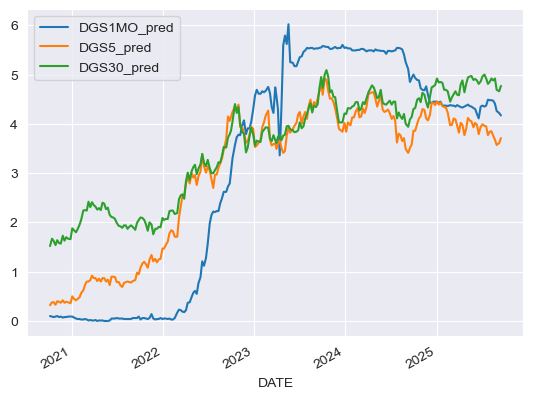

In [9]:
Y.plot()

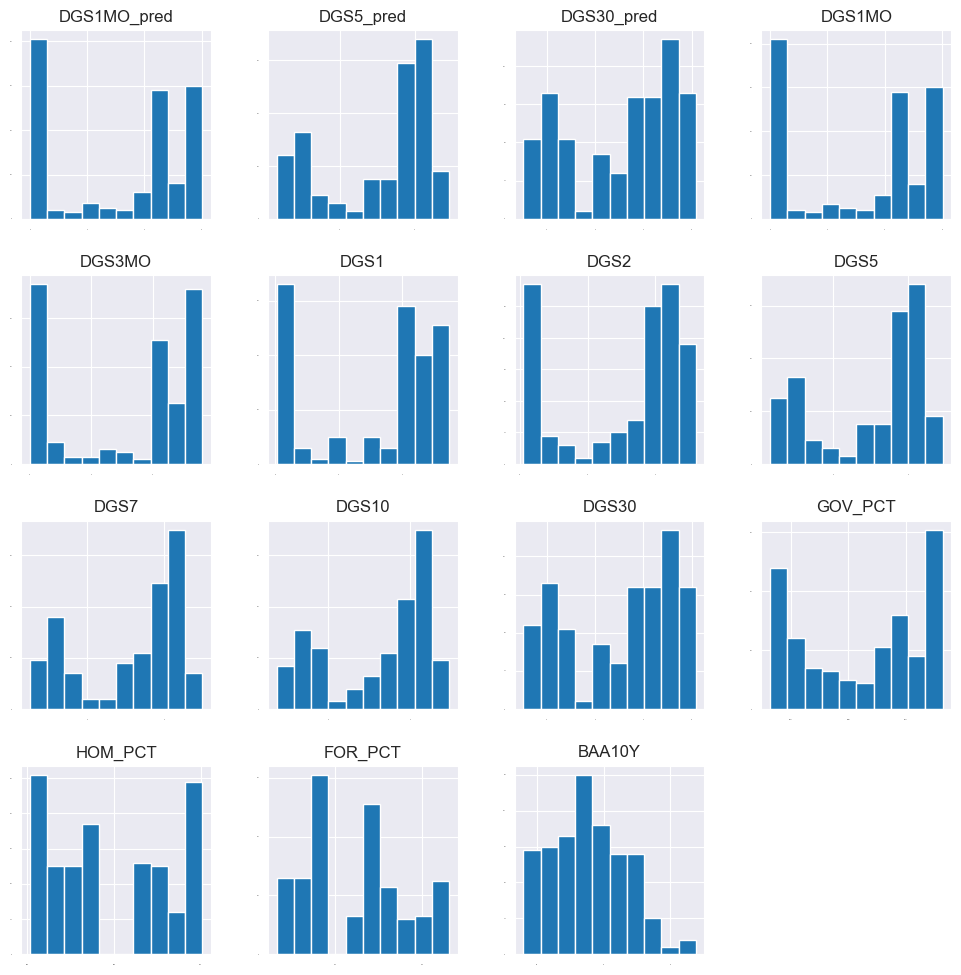

In [10]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

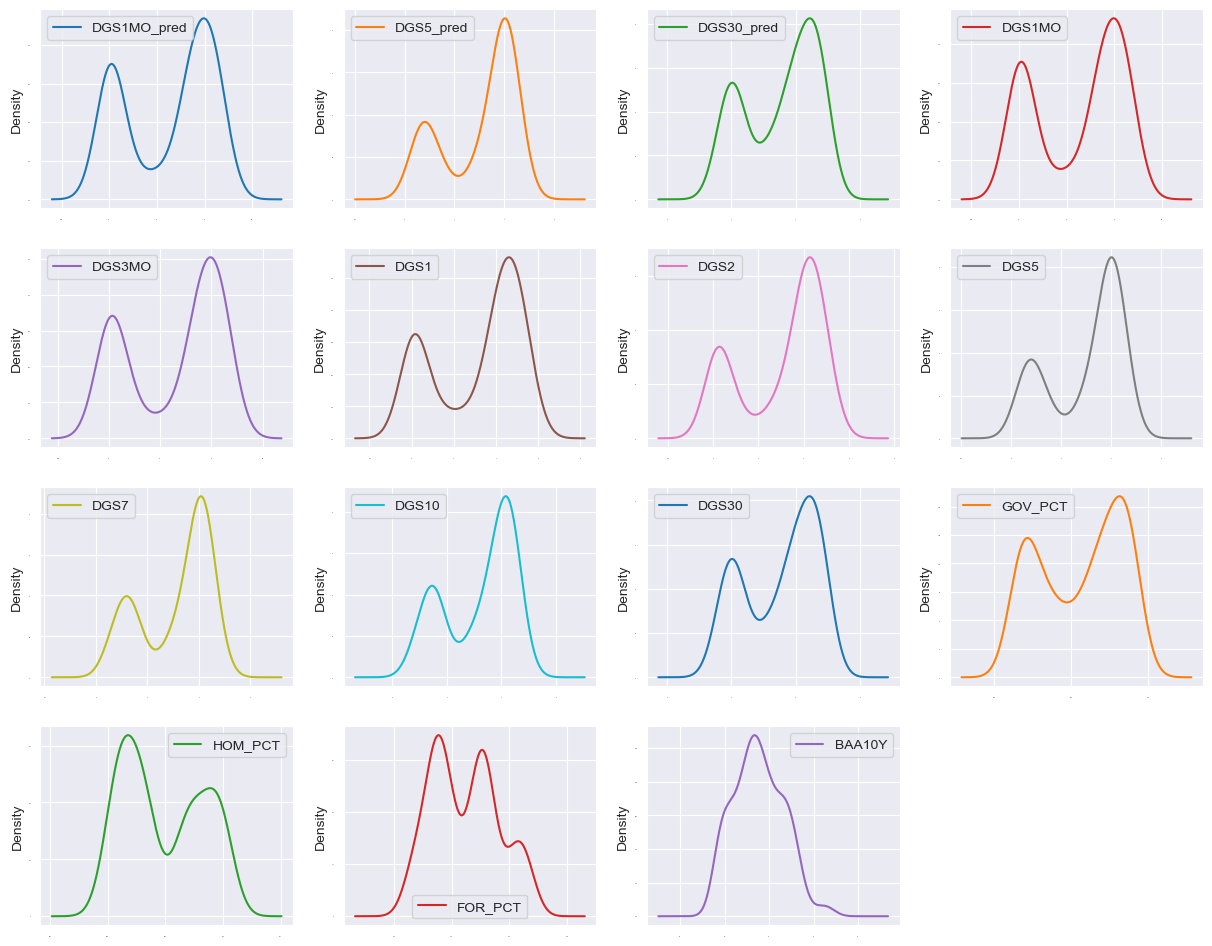

In [11]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

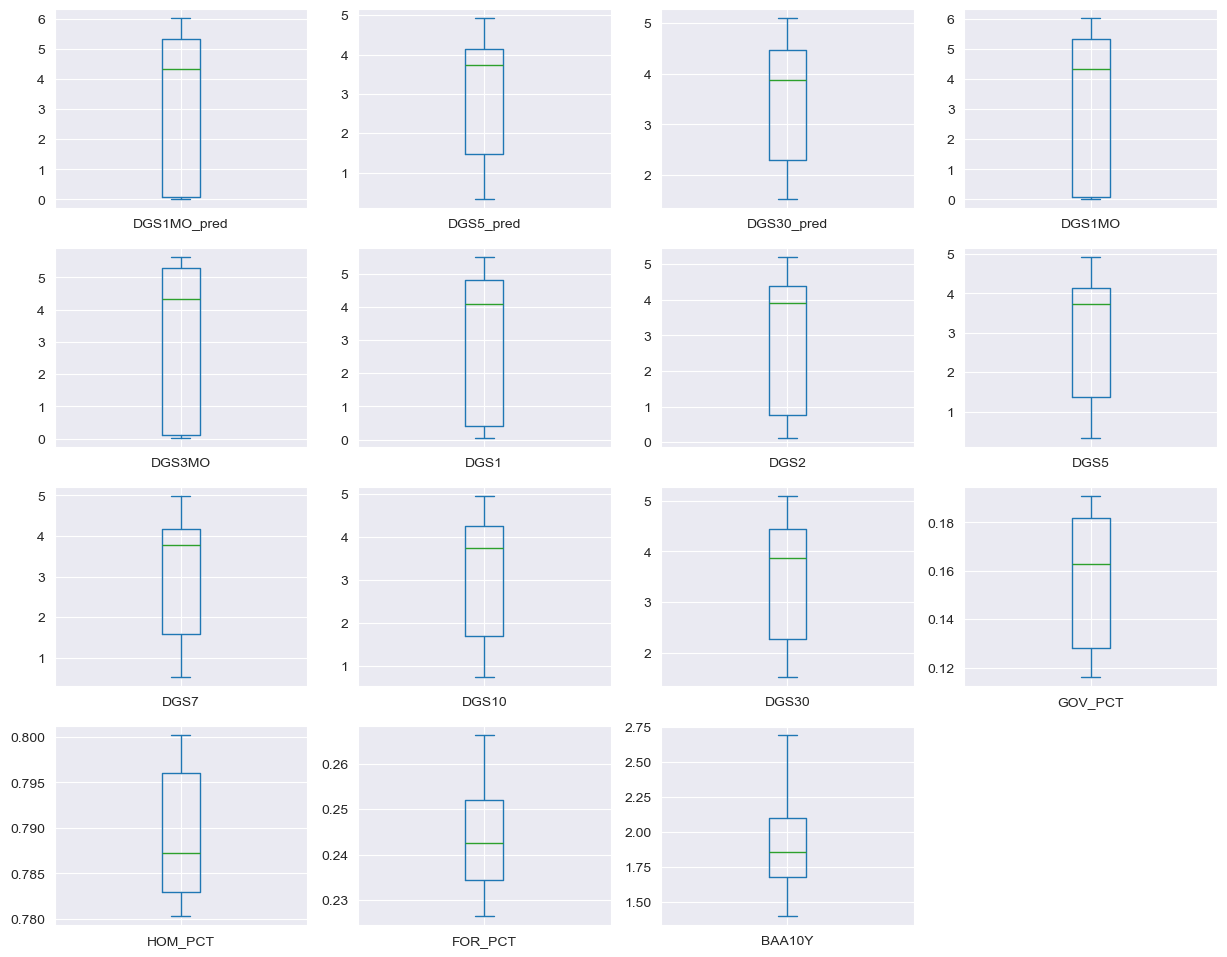

In [12]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

Next We look at the interaction between these variables.

<Axes: title={'center': 'Correlation Matrix'}>

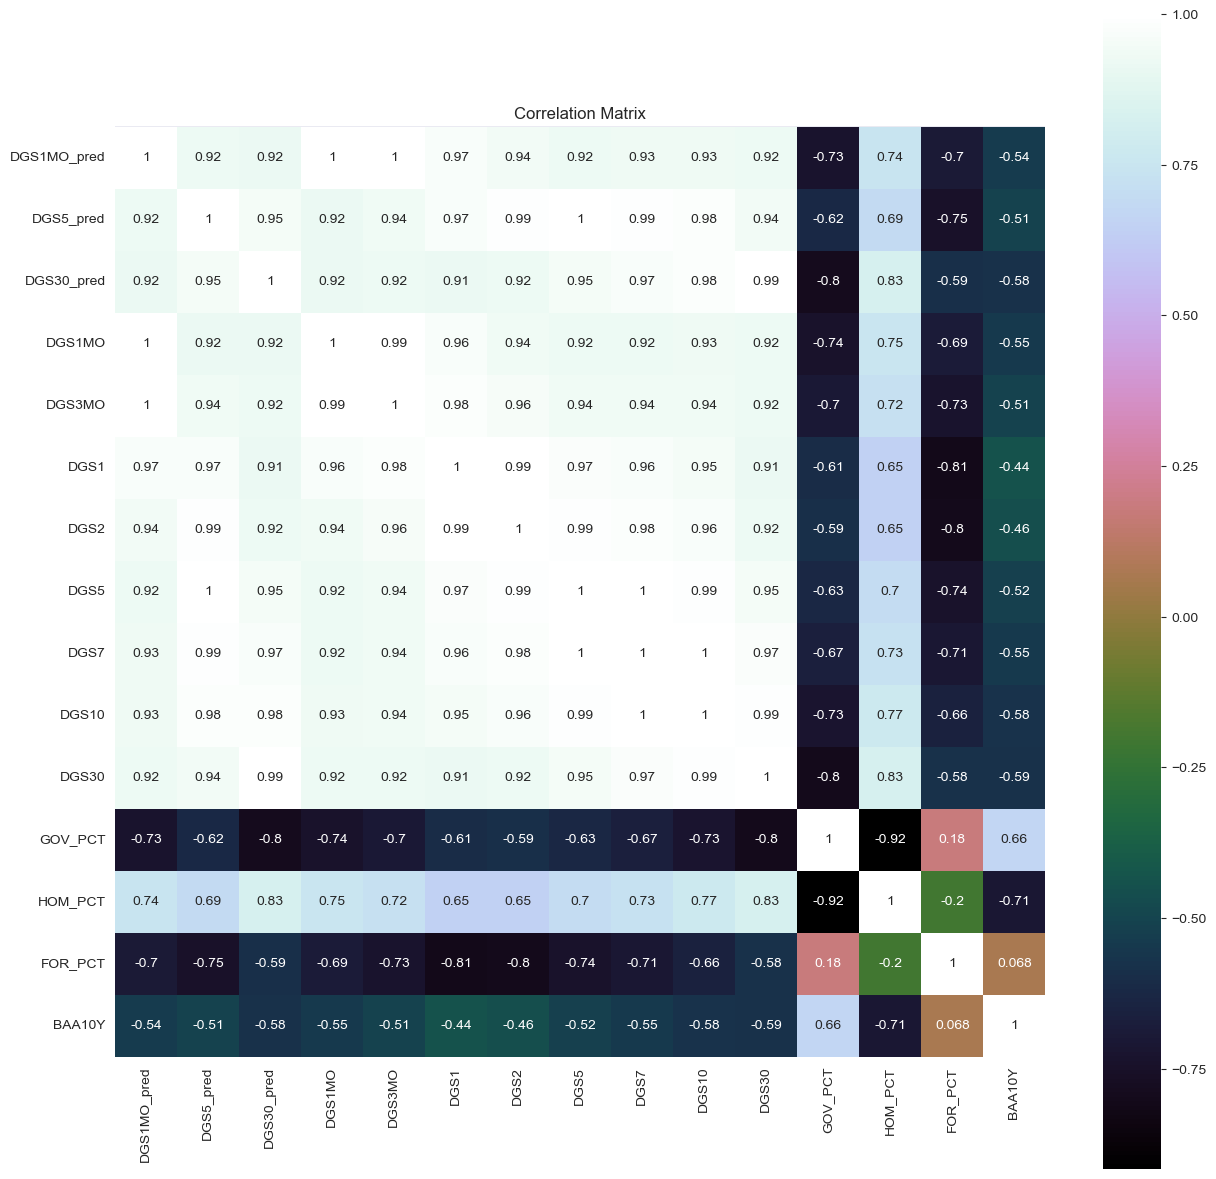

In [13]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

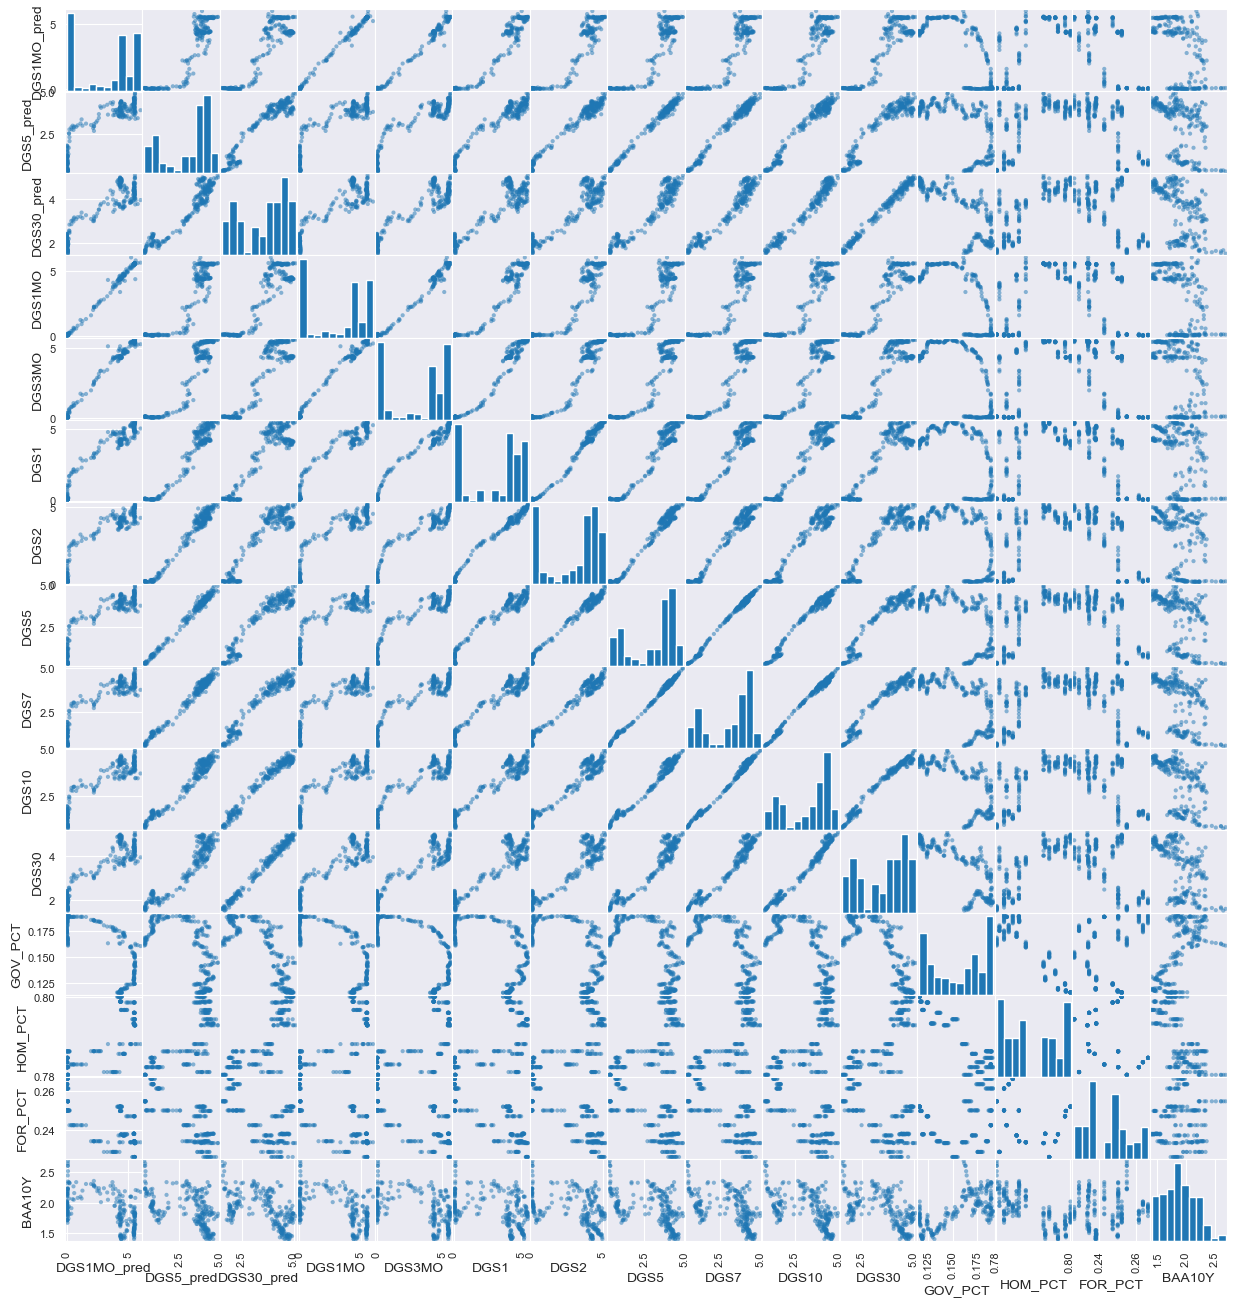

In [14]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

#### 1 Month

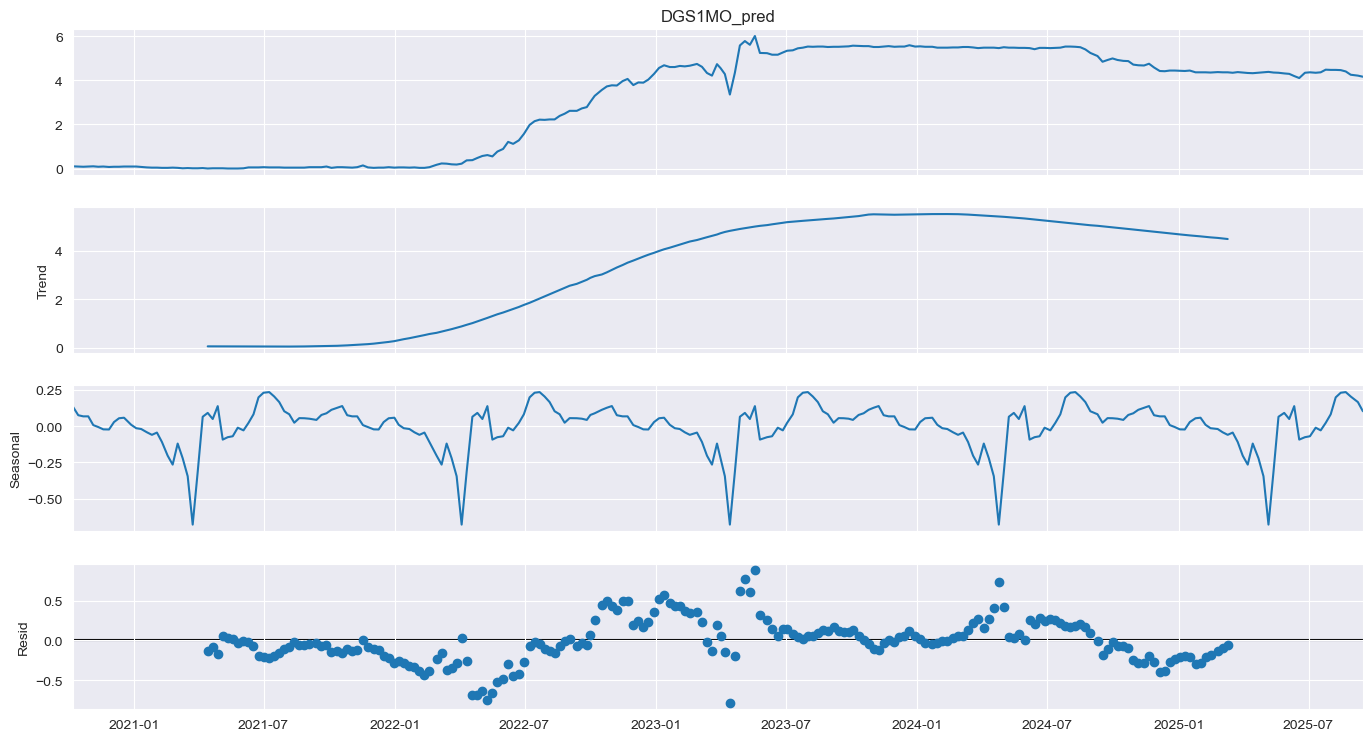

In [15]:
# Données à analyser
temp_Y = dataset['DGS1MO_pred']

# Décomposition de la série temporelle (Remplacement de 'freq' par 'period')
res = sm.tsa.seasonal_decompose(temp_Y, period=52)

# Visualisation des résultats
fig = res.plot()
fig.set_figheight(8)

fig.set_figwidth(15)
pyplot.show()

#### 5 Year

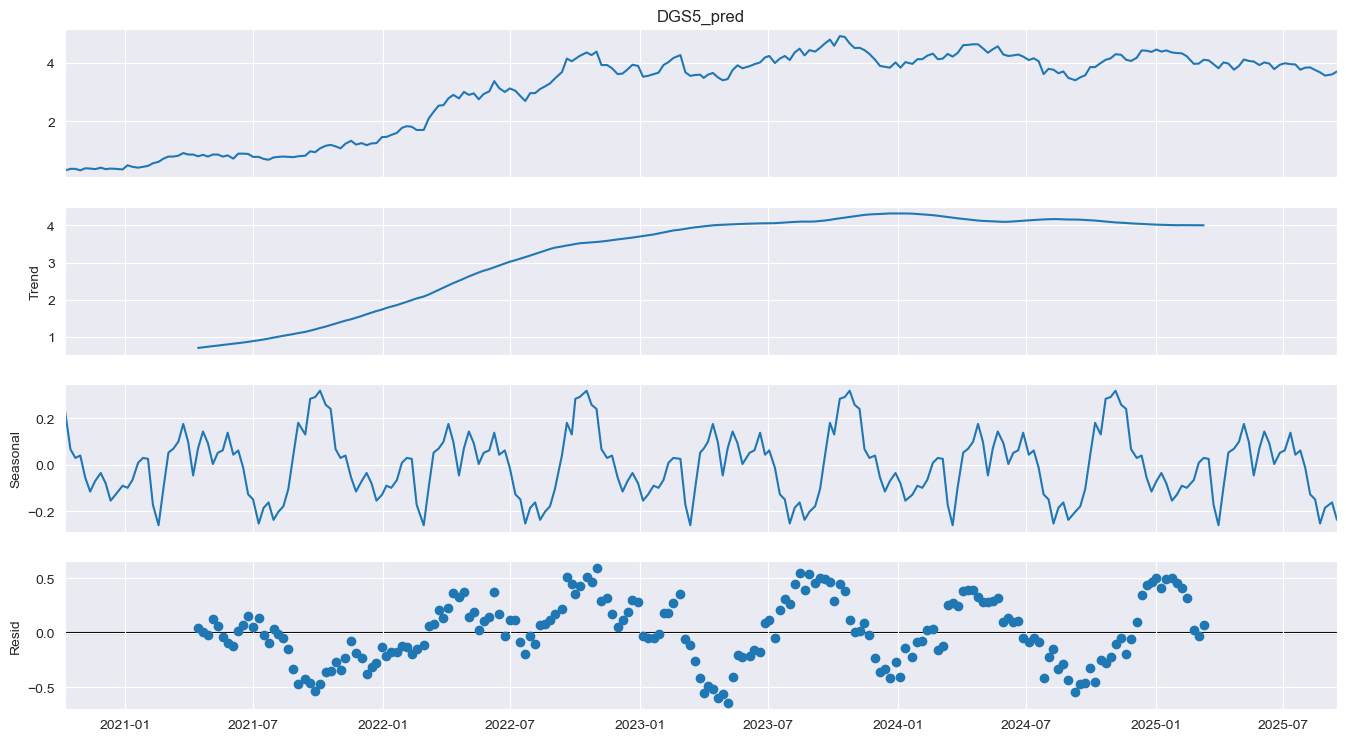

In [16]:
# Supposons que dataset['DGS5_pred'] contienne une série temporelle
temp_Y = dataset['DGS5_pred']

# Remplacez 'freq=52' par 'period=52'
res = sm.tsa.seasonal_decompose(temp_Y, period=52)

# Tracer le résultat
fig = res.plot()
fig.set_figheight(8)

fig.set_figwidth(15)
pyplot.show()

#### 30 Year

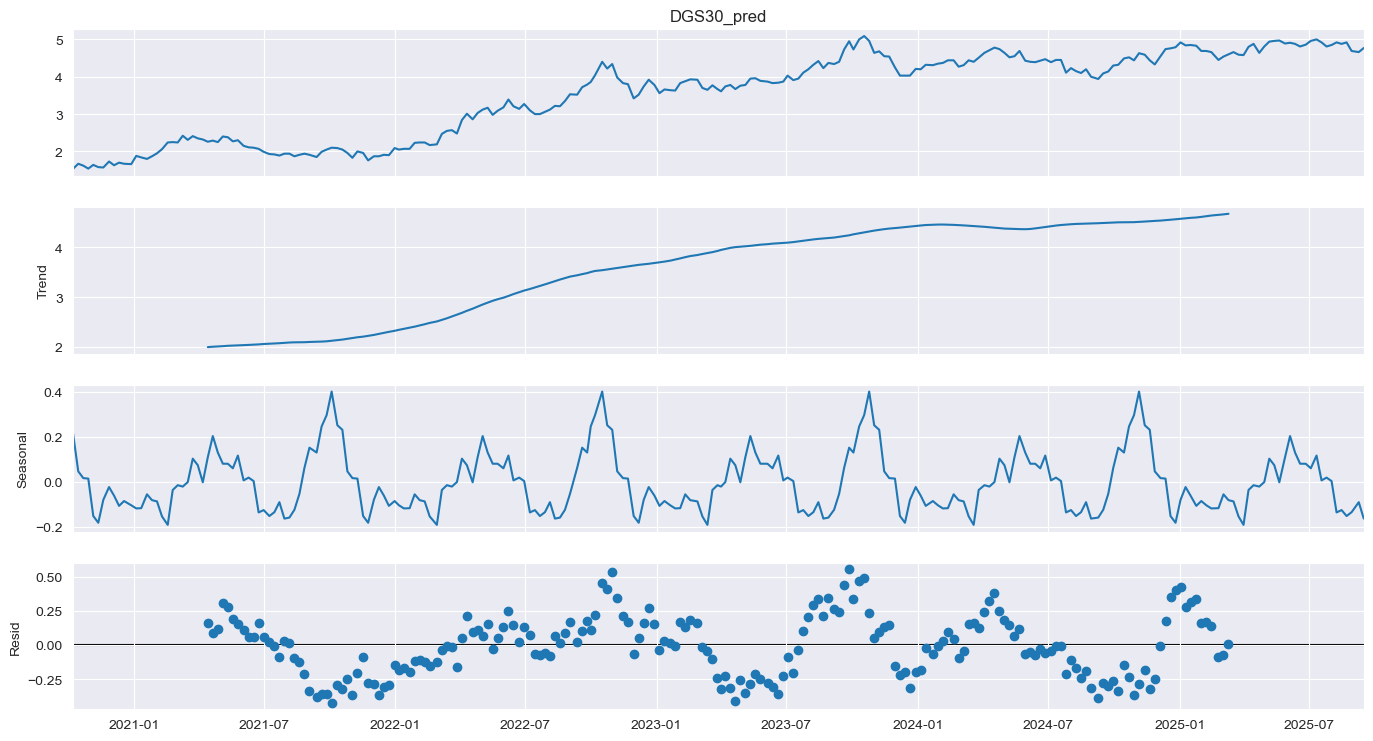

In [17]:

# Supposons que dataset['DGS5_pred'] contienne une série temporelle
temp_Y = dataset['DGS30_pred']

# Remplacez 'freq=52' par 'period=52'
res = sm.tsa.seasonal_decompose(temp_Y, period=52)

# Tracer le résultat
fig = res.plot()
fig.set_figheight(8)

fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

<a id='3'></a>
## 4. Data Preparation and analysis

<a id='3.1'></a>
## 4.1. Univariate Feature Selection

In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
     Specs      Score
0   DGS1MO  51985.128
1   DGS3MO  25545.420
2     DGS1   3648.558
3     DGS2   1977.161
6    DGS10   1529.418
5     DGS7   1491.738
4     DGS5   1443.536
7    DGS30   1341.880
9  HOM_PCT    307.207
8  GOV_PCT    287.812
--------------
DGS5_pred
      Specs      Score
4      DGS5  26369.138
5      DGS7  14599.441
3      DGS2   8799.369
6     DGS10   5986.584
2      DGS1   3733.823
7     DGS30   2042.517
1    DGS3MO   1730.551
0    DGS1MO   1276.982
10  FOR_PCT    316.815
9   HOM_PCT    228.303
--------------
DGS30_pred
     Specs      Score
7    DGS30  19752.369
6    DGS10   7511.220
5     DGS7   3589.632
4     DGS5   2327.394
3     DGS2   1402.727
1   DGS3MO   1341.128
0   DGS1MO   1293.139
2     DGS1   1249.750
9  HOM_PCT    535.069
8  GOV_PCT    431.202
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and evaluation metrics

In [19]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [20]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

In [21]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [22]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.020261715220187 
Std CV Error: (0.013077874232430502) 
Training Error:
0.016539638939934858 
Test Error:
0.019096041651046988
----------
LASSO: 
Average CV error: 0.34712064203582377 
Std CV Error: (0.11850719103694873) 
Training Error:
0.3299822989166056 
Test Error:
0.3603074619610926
----------
EN: 
Average CV error: 0.19630562894395373 
Std CV Error: (0.04233293656851385) 
Training Error:
0.1892669191351236 
Test Error:
0.22241755226425586
----------
KNN: 
Average CV error: 0.02562108666666667 
Std CV Error: (0.01396430067555758) 
Training Error:
0.016633166666666678 
Test Error:
0.01876832000000001
----------
CART: 
Average CV error: 0.04882516666666668 
Std CV Error: (0.026518245076110645) 
Training Error:
0.0 
Test Error:
0.02761466666666666
----------
MLP: 
Average CV error: 0.29894576282977214 
Std CV Error: (0.12739587544287803) 
Training Error:
0.4593373218987987 
Test Error:
0.5847795808927191
----------


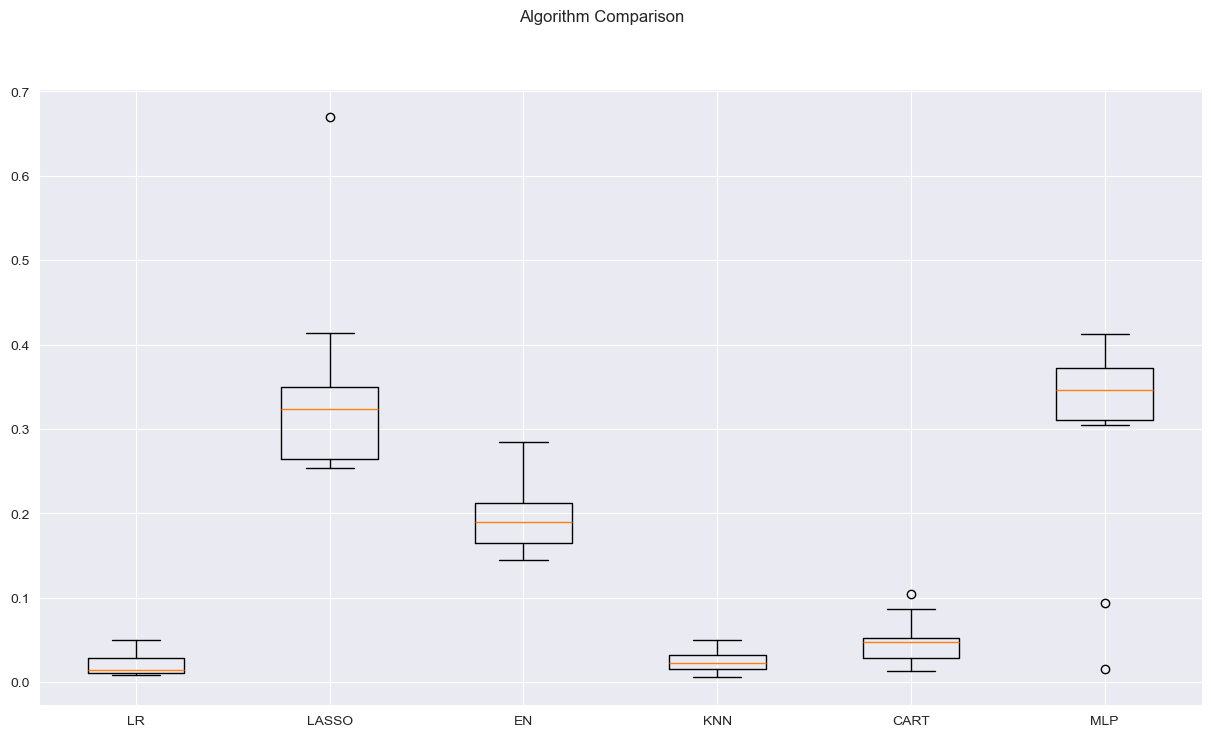

In [23]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

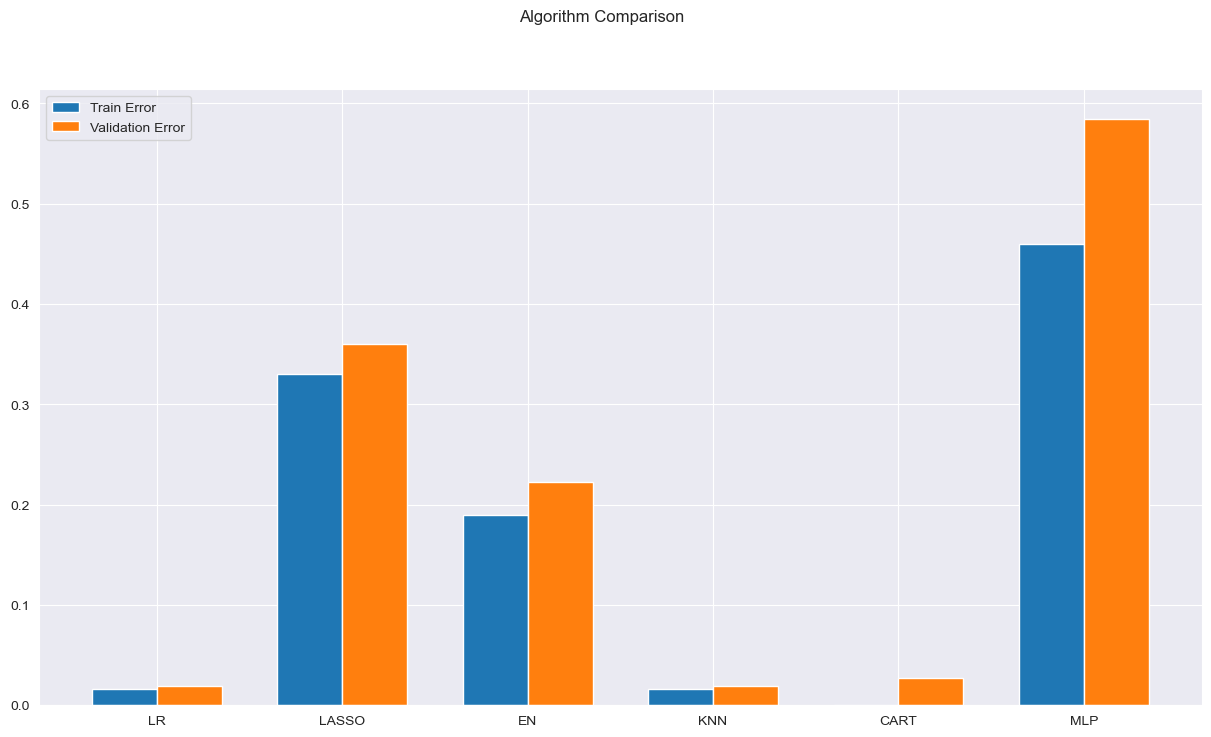

In [24]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [25]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''


# Paramètres
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
seed = 42
scoring = 'accuracy'
model = MLPRegressor()


kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))



Best: nan using {'hidden_layer_sizes': (20,)}
nan (nan) with: {'hidden_layer_sizes': (20,)}
nan (nan) with: {'hidden_layer_sizes': (50,)}
nan (nan) with: {'hidden_layer_sizes': (20, 20)}
nan (nan) with: {'hidden_layer_sizes': (20, 30, 20)}


<a id='6'></a>
# 7. Finalise the Model

In [26]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

<a id='6.1'></a>
## 7.1. Results and comparison of Regression and MLP

In [27]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))


MSE Regression = 0.019096, MSE MLP = 0.047383
R2 Regression = 0.991354, R2 MLP = 0.977674


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [28]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


<Axes: xlabel='DATE'>

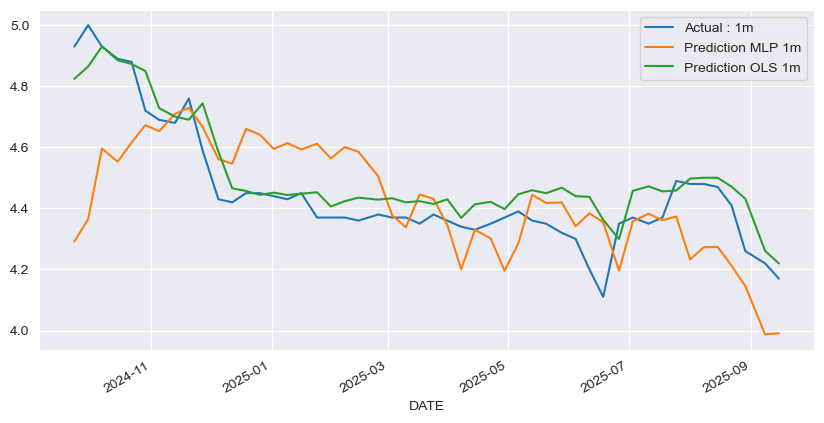

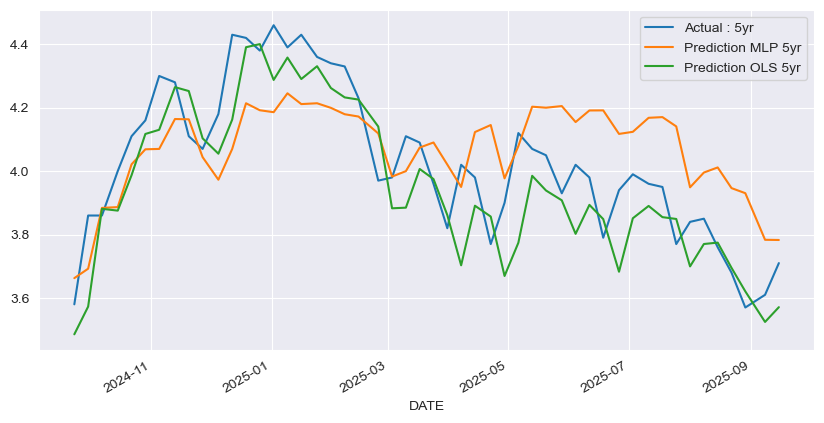

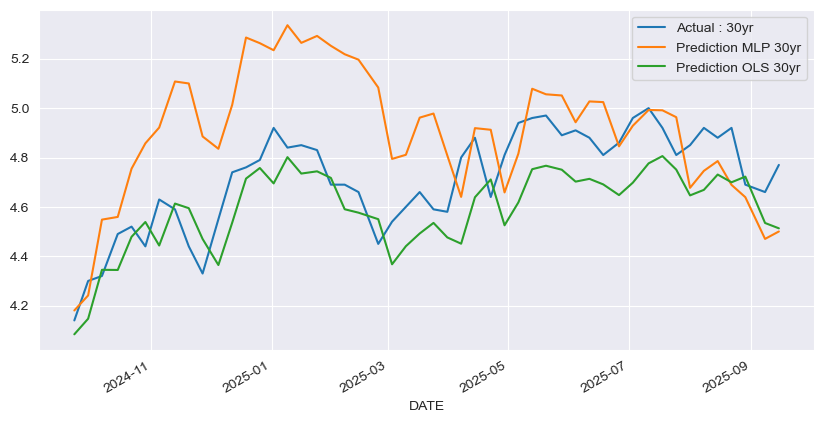

In [29]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))



Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.